In [1]:
%load_ext autoreload
%autoreload 2
import os
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/braindecode/')

# Amplitude Perturbation Visualization


In this tutorial, we show how to use perturbations of the input amplitudes to learn something about the trained convolutional networks. For more background, see [Deep learning with convolutional neural networks for EEG decoding and visualization](https://arxiv.org/abs/1703.05051), Section A.5.2.

First we will do some cross-subject decoding, again using the [Physiobank EEG Motor Movement/Imagery Dataset](https://www.physionet.org/physiobank/database/eegmmidb/), this time to decode imagined left hand vs. imagined right hand movement.


<div class="alert alert-warning">

This tutorial might be very slow if you are not using a GPU.

</div>

## Enable logging

In [2]:
import logging
import importlib
importlib.reload(logging) # see https://stackoverflow.com/a/21475297/1469195
log = logging.getLogger()
log.setLevel('INFO')
import sys
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

## Load data

In [3]:
import mne
import numpy as np
from mne.io import concatenate_raws
from braindecode.datautil.signal_target import SignalAndTarget

# First 50 subjects as train
physionet_paths = [ mne.datasets.eegbci.load_data(sub_id,[4,8,12,]) for sub_id in range(1,51)]
physionet_paths = np.concatenate(physionet_paths)
parts = [mne.io.read_raw_edf(path, preload=True,stim_channel='auto')
         for path in physionet_paths] 

raw = concatenate_raws(parts)

picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

events = mne.find_events(raw, shortest_event=0, stim_channel='STI 014')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epoched = mne.Epochs(raw, events, dict(hands=2, feet=3), tmin=1, tmax=4.1, proj=False, picks=picks,
                baseline=None, preload=True)

# 51-55 as validation subjects
physionet_paths_valid = [mne.datasets.eegbci.load_data(sub_id,[4,8,12,]) for sub_id in range(51,56)]
physionet_paths_valid = np.concatenate(physionet_paths_valid)
parts_valid = [mne.io.read_raw_edf(path, preload=True,stim_channel='auto')
         for path in physionet_paths_valid]
raw_valid = concatenate_raws(parts_valid)

picks_valid = mne.pick_types(raw_valid.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

events_valid = mne.find_events(raw_valid, shortest_event=0, stim_channel='STI 014')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epoched_valid = mne.Epochs(raw_valid, events_valid, dict(hands=2, feet=3), tmin=1, tmax=4.1, proj=False, picks=picks_valid,
                baseline=None, preload=True)

train_X = (epoched.get_data() * 1e6).astype(np.float32)
train_y = (epoched.events[:,2] - 2).astype(np.int64) #2,3 -> 0,1
valid_X = (epoched_valid.get_data() * 1e6).astype(np.float32)
valid_y = (epoched_valid.events[:,2] - 2).astype(np.int64) #2,3 -> 0,1
train_set = SignalAndTarget(train_X, y=train_y)
valid_set = SignalAndTarget(valid_X, y=valid_y)

## Create the model

We use the deep ConvNet from [Deep learning with convolutional neural networks for EEG decoding and visualization](https://arxiv.org/abs/1703.05051) (Section 2.4.2).


In [4]:
from braindecode.models.deep4 import Deep4Net
from torch import nn
from braindecode.torch_ext.util import set_random_seeds
from braindecode.models.util import to_dense_prediction_model

# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.
cuda = True
set_random_seeds(seed=20170629, cuda=cuda)

# This will determine how many crops are processed in parallel
input_time_length = 450
# final_conv_length determines the size of the receptive field of the ConvNet
model = Deep4Net(in_chans=64, n_classes=2, input_time_length=input_time_length,
                 filter_length_3=5, filter_length_4=5,
                 pool_time_stride=2,
                 stride_before_pool=True,
                        final_conv_length=1)
if cuda:
    model.cuda()

In [5]:
from braindecode.torch_ext.optimizers import AdamW
import torch.nn.functional as F
optimizer = AdamW(model.parameters(), lr=1*0.01, weight_decay=0.5*0.001) # these are good values for the deep model
model.compile(loss=F.nll_loss, optimizer=optimizer,  iterator_seed=1, cropped=True)

## Run the training

In [6]:
input_time_length = 450
model.fit(train_set.X, train_set.y, epochs=30, batch_size=64, scheduler='cosine',
          input_time_length=input_time_length,
         validation_data=(valid_set.X, valid_set.y),)

2018-08-27 12:04:33,164 INFO : Run until first stop...
2018-08-27 12:04:34,651 INFO : Epoch 0
2018-08-27 12:04:34,652 INFO : train_loss                3.30341
2018-08-27 12:04:34,655 INFO : valid_loss                3.40263
2018-08-27 12:04:34,657 INFO : train_misclass            0.51359
2018-08-27 12:04:34,658 INFO : valid_misclass            0.53052
2018-08-27 12:04:34,660 INFO : runtime                   0.00000
2018-08-27 12:04:34,662 INFO : 
2018-08-27 12:04:36,947 INFO : Time only for training updates: 1.89s
2018-08-27 12:04:38,297 INFO : Epoch 1
2018-08-27 12:04:38,298 INFO : train_loss                0.67976
2018-08-27 12:04:38,299 INFO : valid_loss                0.61942
2018-08-27 12:04:38,300 INFO : train_misclass            0.41846
2018-08-27 12:04:38,301 INFO : valid_misclass            0.30516
2018-08-27 12:04:38,302 INFO : runtime                   3.78315
2018-08-27 12:04:38,303 INFO : 
2018-08-27 12:04:40,568 INFO : Time only for training updates: 1.88s
2018-08-27 12:0

2018-08-27 12:05:35,655 INFO : valid_misclass            0.16432
2018-08-27 12:05:35,655 INFO : runtime                   3.58996
2018-08-27 12:05:35,656 INFO : 
2018-08-27 12:05:37,934 INFO : Time only for training updates: 1.89s
2018-08-27 12:05:39,250 INFO : Epoch 18
2018-08-27 12:05:39,252 INFO : train_loss                0.56666
2018-08-27 12:05:39,252 INFO : valid_loss                0.46518
2018-08-27 12:05:39,253 INFO : train_misclass            0.23711
2018-08-27 12:05:39,254 INFO : valid_misclass            0.12676
2018-08-27 12:05:39,254 INFO : runtime                   3.58806
2018-08-27 12:05:39,255 INFO : 
2018-08-27 12:05:41,566 INFO : Time only for training updates: 1.89s
2018-08-27 12:05:42,999 INFO : Epoch 19
2018-08-27 12:05:43,000 INFO : train_loss                0.55883
2018-08-27 12:05:43,000 INFO : valid_loss                0.47641
2018-08-27 12:05:43,001 INFO : train_misclass            0.23805
2018-08-27 12:05:43,005 INFO : valid_misclass            0.10798
201

## Compute correlation: amplitude perturbation - prediction change

First collect all batches and concatenate them into one array of examples:

In [7]:
from braindecode.datautil.iterators import CropsFromTrialsIterator
from braindecode.torch_ext.util import np_to_var
test_input = np_to_var(np.ones((2, 64, input_time_length, 1), dtype=np.float32))
if cuda:
    test_input = test_input.cuda()
out = model.network(test_input)
n_preds_per_input = out.cpu().data.numpy().shape[2]
iterator = CropsFromTrialsIterator(batch_size=32,input_time_length=input_time_length,
                                  n_preds_per_input=n_preds_per_input)

train_batches = list(iterator.get_batches(train_set, shuffle=False))
train_X_batches = np.concatenate(list(zip(*train_batches))[0])

Next, create a prediction function that wraps the model prediction function and returns the predictions as numpy arrays. We use the predition before the softmax, so we create a new module with all the layers of the old until before the softmax.

In [8]:
from torch import nn
from braindecode.torch_ext.util import var_to_np
import torch as th
new_model = nn.Sequential()
for name, module in model.network.named_children():
    if name == 'softmax': break
    new_model.add_module(name, module)

new_model.eval();
pred_fn = lambda x: var_to_np(th.mean(new_model(np_to_var(x).cuda())[:,:,:,0], dim=2, keepdim=False))

In [16]:
from braindecode.visualization.perturbation import compute_amplitude_prediction_correlations


amp_pred_corrs = compute_amplitude_prediction_correlations(pred_fn, train_X_batches, n_iterations=12,
                                         batch_size=30)

2018-08-08 12:19:10,049 INFO : Compute original predictions...
2018-08-08 12:19:27,871 INFO : Iteration 0...
2018-08-08 12:19:27,873 INFO : Sample perturbation...
2018-08-08 12:19:37,305 INFO : Compute perturbed complex inputs...
2018-08-08 12:19:50,788 INFO : Compute perturbed real inputs...
2018-08-08 12:20:08,863 INFO : Compute new predictions...
2018-08-08 12:20:09,609 INFO : Layer 0...
2018-08-08 12:20:09,610 INFO : Compute activation difference...
2018-08-08 12:20:09,611 INFO : Compute correlation...
2018-08-08 12:20:13,067 INFO : Iteration 1...
2018-08-08 12:20:13,068 INFO : Sample perturbation...
2018-08-08 12:20:20,858 INFO : Compute perturbed complex inputs...
2018-08-08 12:20:30,561 INFO : Compute perturbed real inputs...
2018-08-08 12:20:45,390 INFO : Compute new predictions...
2018-08-08 12:20:46,164 INFO : Layer 0...
2018-08-08 12:20:46,165 INFO : Compute activation difference...
2018-08-08 12:20:46,166 INFO : Compute correlation...
2018-08-08 12:20:49,880 INFO : Iteratio

## Plot correlations

Pick out one frequency range and mean correlations within that frequency range to make a scalp plot.
Here we use the alpha frequency range.

In [19]:
amp_pred_corrs.shape

(64, 226, 2)

In [20]:

fs = epoched.info['sfreq']
freqs = np.fft.rfftfreq(train_X_batches.shape[2], d=1.0/fs)
start_freq = 7
stop_freq = 14

i_start = np.searchsorted(freqs,start_freq)
i_stop = np.searchsorted(freqs, stop_freq) + 1

freq_corr = np.mean(amp_pred_corrs[:,i_start:i_stop], axis=1)

Now get approximate positions of the channels in the 10-20 system.

In [21]:
from braindecode.datasets.sensor_positions import get_channelpos, CHANNEL_10_20_APPROX

ch_names = [s.strip('.') for s in epoched.ch_names]
positions = [get_channelpos(name, CHANNEL_10_20_APPROX) for name in ch_names]
positions = np.array(positions)

### Plot with MNE

In [22]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
max_abs_val = np.max(np.abs(freq_corr))

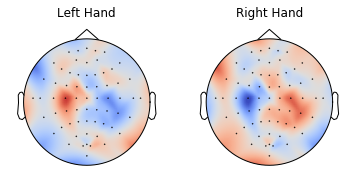

In [23]:
fig, axes = plt.subplots(1, 2)
class_names = ['Left Hand', 'Right Hand']
for i_class in range(2):
    ax = axes[i_class]
    mne.viz.plot_topomap(freq_corr[:,i_class], positions,
                     vmin=-max_abs_val, vmax=max_abs_val, contours=0,
                    cmap=cm.coolwarm, axes=ax, show=False);
    ax.set_title(class_names[i_class])

### Plot with Braindecode

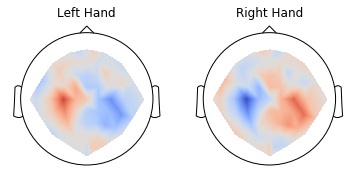

In [24]:
from braindecode.visualization.plot import ax_scalp

fig, axes = plt.subplots(1, 2)
class_names = ['Left Hand', 'Right Hand']
for i_class in range(2):
    ax = axes[i_class]
    ax_scalp(freq_corr[:,i_class], ch_names, chan_pos_list=CHANNEL_10_20_APPROX, cmap=cm.coolwarm,
            vmin=-max_abs_val, vmax=max_abs_val, ax=ax)
    ax.set_title(class_names[i_class])

From these plots we can see the ConvNet clearly learned to use the lateralized response in the alpha band. Note that the positive correlations for the left hand on the left side do not imply an increase of alpha activity for the left hand in the data, see  [Deep learning with convolutional neural networks for EEG decoding and visualization](https://arxiv.org/abs/1703.05051) Result 12 for some notes on interpretability.

## Dataset references


 This dataset was created and contributed to PhysioNet by the developers of the [BCI2000](http://www.schalklab.org/research/bci2000) instrumentation system, which they used in making these recordings. The system is described in:
 
     Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. (2004) BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. IEEE TBME 51(6):1034-1043.

[PhysioBank](https://physionet.org/physiobank/) is a large and growing archive of well-characterized digital recordings of physiologic signals and related data for use by the biomedical research community and further described in:

    Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. (2000) PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220.